# Aplicando SVM para classificação de rostos

## Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Importando o dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

In [3]:
faces = fetch_olivetti_faces(data_home='~/data/', shuffle=True, random_state=42)

### Particionando

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42)

### Algumas imagens

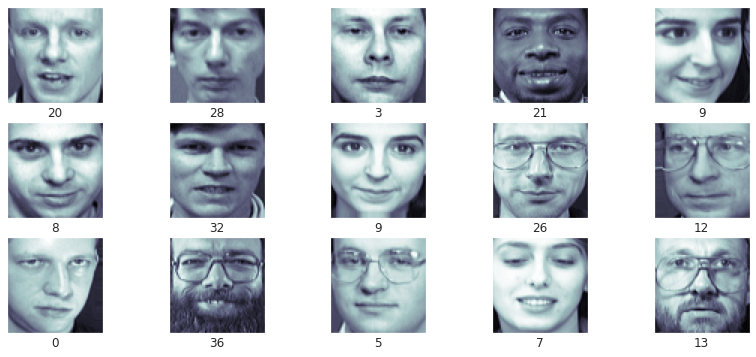

In [5]:
fig, ax = plt.subplots(3, 5, figsize=(14, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], 
            yticks=[],
            xlabel=faces.target[i])

## Pipeline

In [6]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [7]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

## Grid Search

In [8]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {
    'svc__C': [0.01, 0.5, 1, 5, 10, 50],
    'svc__kernel': ['poly', 'rbf', 'sigmoid'],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
    'svc__decision_function_shape':  ['ovo', 'ovr']
}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: user 4min 32s, sys: 3.34 s, total: 4min 35s
Wall time: 46 s
{'svc__C': 10, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [11]:
model = grid.best_estimator_
y_fit = model.predict(X_test)

## Avaliando o modelo

### Imagens e rótulos

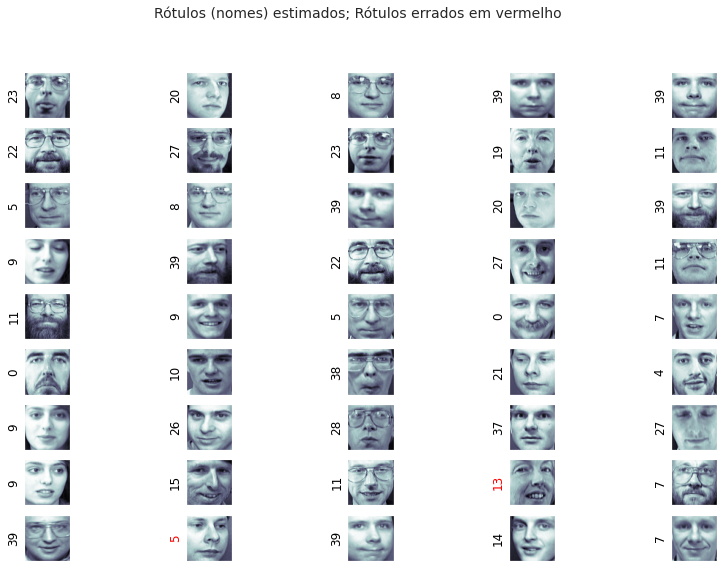

In [24]:
fig, ax = plt.subplots(9, 5, figsize=(14, 9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(faces.images.shape[1], faces.images.shape[2]),
               cmap='bone')
    axi.set(xticks=[], 
            yticks=[])
    axi.set_ylabel(faces.target[y_fit[i]],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Rótulos (nomes) estimados; Rótulos errados em vermelho', size=14);

### Relatório da classificação

In [13]:
from sklearn.metrics import classification_report

In [14]:
print(classification_report(y_test, y_fit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       0.67      0.67      0.67         3
           3       1.00      0.50      0.67         4
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         2
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          12       0.60      1.00      0.75         3
          13       1.00      1.00      1.00         3
          14       0.67      1.00      0.80         4
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         3
          18       1.00    

### Matriz de confusão

In [15]:
from sklearn.metrics import confusion_matrix

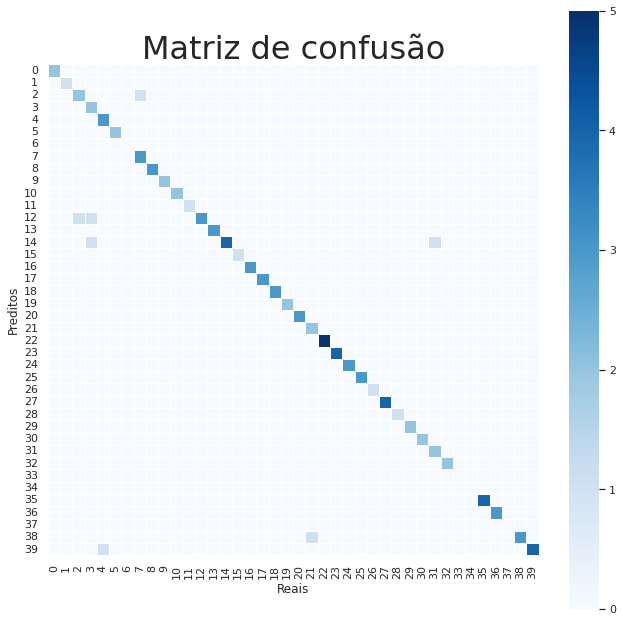

In [42]:
cm = confusion_matrix(y_test, y_fit, labels=range(40))

plt.figure(figsize=(11, 11))
sns.heatmap(cm.T, 
            square=True, 
            cbar=True,
            linewidths=.9,
            cmap=plt.cm.Blues)

plt.title('Matriz de confusão',
          fontdict={'fontsize':32})
plt.xlabel('Reais')
plt.ylabel('Preditos')
# plt.xticks(rotation=0) 

plt.show()